<div style="background-color:white; text-align:center; font-family:Arial, Helvetica, sans-serif; padding:50px;">
  <!-- Tytuł -->
  <div style="color:#993520; font-size:60px; font-weight:bold; margin-bottom:20px;">
    MACHINE LEARNING 2 - REGRESSION PROJECT
  </div>

  <!-- Podtytuł -->
  <div style="color:#993520; font-size:35px; margin-bottom:40px;">
    Used Cars Price Prediction
  </div>

  <!-- Autor -->
  <div style="color:black; font-size:30px; margin-bottom:10px;">
    Aleksandra Dobosz & Wojciech Hrycenko
  </div>

  <!-- Data / semestr -->
  <div style="color:black; font-size:30px; margin-bottom:20px;">
    Autumn 2025
  </div>

### 0. Setup and Imports
Importing necessary libraries and setting global configurations.
Ensures reproducibility and cleaner output presentation.

In [46]:
# Import necessary libraries

import warnings
import re
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print(f"Setup complete. Random seed set to {SEED}.")

Setup complete. Random seed set to 42.


## 1. Introduction and Project Overview
In this project, we aim to develop a machine learning model to predict the prices of used cars based on various features. Accurate price prediction can assist buyers and sellers in making informed decisions in the used car market.

### 1.1 About Dataset
Craigslist is the world's largest collection of used vehicles for sale. We used import posted on Kaggle which includes every used vehicle entry within the United States on Craigslist. This data is scraped every few months, it contains most all relevant information that Craigslist provides on car sales including columns like price, condition, manufacturer, latitude/longitude, and 18 other categories.

### 1.2 Project Objectives
* **Data Cleaning:** Handle missing values and remove outliers (for example unrealistic prices).
* **Feature Engineering:** Extract meaningful features from existing data (for example vehicle age, luxury status).
* **Modeling:** Implement and compare multiple regression algorithms (Linear, Random Forest, XGBoost, Neural Networks).
* **Optimization:** Apply hyperparameter tuning and ensembling to achieve the best performance.

## 2. Data Quality Assessment
Before cleaning, we must understand the "health" of the data. We will analyze:
1.  **Missing Values:** Identifying columns with excessive gaps (for example >40% missing).
2.  **Cardinality:** Checking unique values to identify ID columns (useless for regression) or constant columns.
3.  **Duplicates:** Checking for repeated entries.

In [47]:
def load_and_audit_data(filepath):
    try:
        print(f"Loading data from '{filepath}'...")
        df = pd.read_csv(filepath)
        
        print(f"--- Data Shape: {df.shape} (Rows, Cols) ---")
        
        duplicates = df.duplicated().sum()
        print(f"--- Duplicates Found: {duplicates} ---")
        
        missing = df.isna().sum()
        missing_pct = (missing / len(df)) * 100
        unique_vals = df.nunique()
        
        report = pd.DataFrame({
            'Missing Count': missing, 
            'Missing %': missing_pct,
            'Unique Values': unique_vals
        })
        
        report = report.sort_values(by=['Missing %', 'Unique Values'], ascending=False)
        
        print("\n--- Data Quality Report (Top 20 Columns) ---")
        display(report.head(20))
        
        return df
    
    except FileNotFoundError:
        print(f"Error: File '{filepath}' not found.")
        return None

df_raw = load_and_audit_data('vehicles.csv')

Loading data from 'vehicles.csv'...
--- Data Shape: (426880, 26) (Rows, Cols) ---
--- Duplicates Found: 0 ---

--- Data Quality Report (Top 20 Columns) ---


,Missing Count,Missing %,Unique Values
county,426880,100.000000,0
size,306361,71.767476,4
cylinders,177678,41.622470,8
condition,174104,40.785232,6
VIN,161042,37.725356,118264
drive,130567,30.586347,3
paint_color,130203,30.501078,12
type,92858,21.752717,13
manufacturer,17646,4.133714,42
title_status,8242,1.930753,6


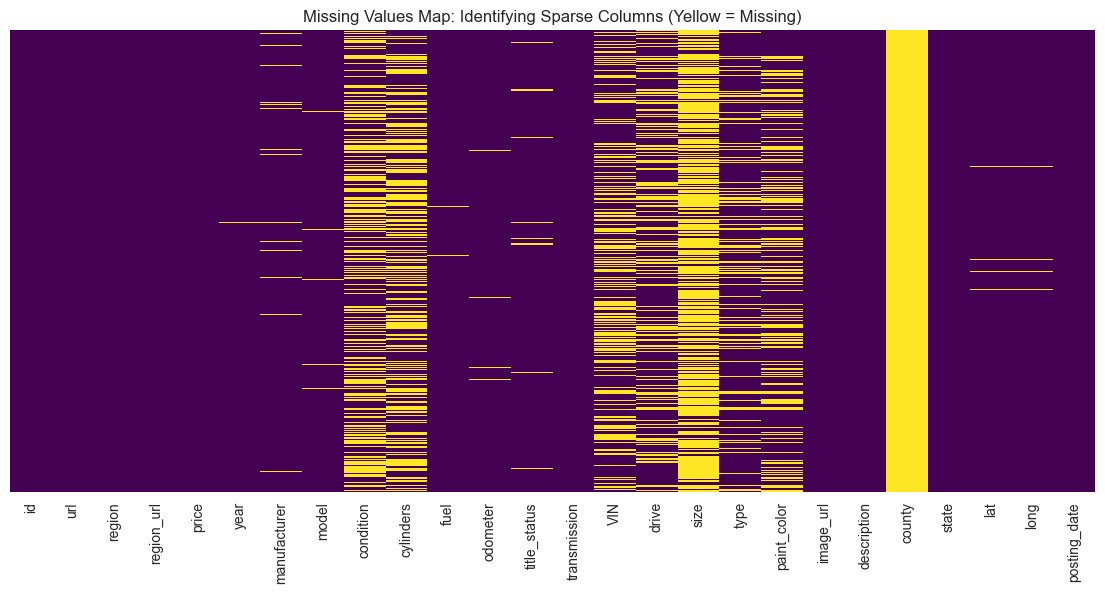

In [48]:
# Heatmap of missing values: Yellow lines indicate missing data
plt.figure(figsize=(14, 6))
sns.heatmap(df_raw.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Map: Identifying Sparse Columns (Yellow = Missing)')
plt.show()

### 2.1 Cleaning Decision Logic
Based on the Quality Assessment Report, we apply the following cleaning strategy to prepare the dataset for regression:

1. **Drop High-Missing Columns:**
   * `county`: **100% missing**. Completely empty feature.
   * `size`: **~71.8% missing**. Imputing this would introduce significant noise.

2. **Drop Irrelevant, Technical, or Unstructured Columns:**
   * `id`, `url`, `image_url`, `region_url`: Metadata not relevant for price prediction.
   * `VIN`: Unique identifier (~37% missing). Too sparse and high-cardinality.
   * `lat`, `long`: Geospatial data (requires external API or complex feature engineering).
   * `posting_date`: Temporal data (irrelevant for this snapshot analysis).
   * `description`: Unstructured text.

3. **Handle Duplicates:**
   * We apply deduplication to ensure pipeline robustness.

4. **Row-wise Dropping (Critical Features):**
   * Remove rows where **Target Variable (`price`)** is missing.
   * Remove rows where critical predictors (`year`, `odometer`) are missing.

In [ ]:
def clean_initial_data(df):
    """
    Applies cleaning logic derived from the Quality Assessment.
    Drops irrelevant columns and rows with missing critical data.
    """
    df_clean = df.copy()
    
    cols_to_drop = [
        'id', 'url', 'region_url', 'image_url', 'size', 
        'county', 'VIN', 'lat', 'long', 'posting_date', 'description'
    ]
    
    existing_drop = [c for c in cols_to_drop if c in df_clean.columns]
    df_clean = df_clean.drop(columns=existing_drop)
    
    df_clean = df_clean.drop_duplicates()
    
    df_clean = df_clean.dropna(subset=['price', 'year', 'odometer'])
    
    print(f"Cleaning complete.")
    print(f"New Data Shape: {df_clean.shape}")
    
    return df_clean

df_clean_step1 = clean_initial_data(df_raw)

Cleaning complete. Dropped 4374 rows with missing critical info.
New Data Shape: (366015, 15)


### 2.2 Missing Values Imputation
Instead of dropping rows with missing categorical data (for example `fuel`, `transmission`, `condition`), we impute them with a placeholder `'unknown'`.

**Reasoning:**
1. **Data Preservation:** Dropping these rows would discard valid price/year/mileage data.
2. **Bias Reduction:** Vehicles with missing descriptions might be older or cheaper; removing them could bias the model towards higher-end listings.

In [49]:
def impute_missing_values(df):
    """
    Fills missing categorical values with 'unknown' to preserve data volume.
    """
    df_filled = df.copy()
    
    cat_cols = [
        'manufacturer', 'model', 'condition', 'cylinders', 
        'fuel', 'title_status', 'transmission', 'drive', 'type', 'paint_color'
    ]
    
    cols_to_fill = [c for c in cat_cols if c in df_filled.columns]
    
    df_filled[cols_to_fill] = df_filled[cols_to_fill].fillna('unknown')
            
    print(f"Imputation complete. Remaining missing values: {df_filled.isna().sum().sum()}")
    return df_filled

df_imputed = impute_missing_values(df_clean_step1)

Imputation complete. Remaining missing values: 0


## 3. Outlier Detection and Removal
Craigslist data often contains unrealistic values due to user error or spam (for example price $0, price $12345678, year 2999).

**Filtering Logic:**
* **Price:** Keep \$500 - \$150,000 (Removes junk cars and super-luxury outliers/errors).
* **Year:** Keep > 1990 and <= 2025 (Focus on modern market; removes future dates).
* **Odometer:** Keep 0 - 400,000 miles (Removes negatives and likely data entry errors).
* **Final Cleanup:** Remove any remaining rows with NaN values after filtering.

**Visualization:**
After cleaning, we verify the data distribution using histograms and boxplots.

Outlier Removal Summary:
  Original: 366015
  Retained: 322976
  Dropped:  43039 (11.76%)


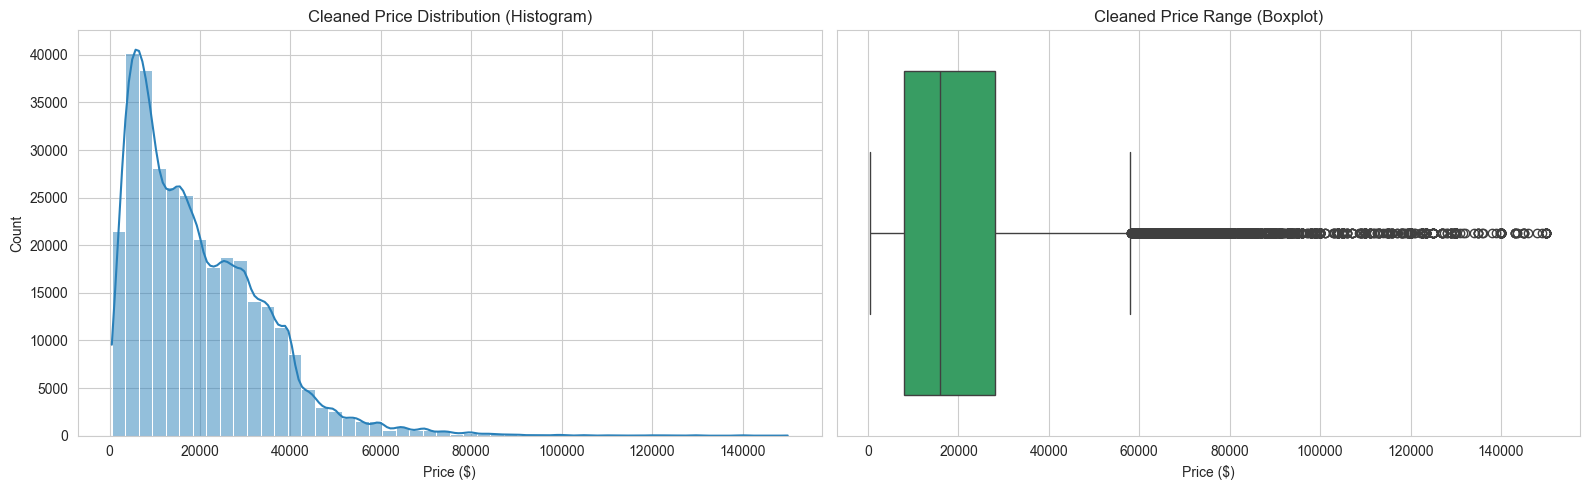

In [50]:
def remove_outliers(df, price_min=500, price_max=150000, year_min=1990, odo_max=400000):
    """
    Filters out rows based on domain-knowledge thresholds to improve model stability.
    Returns: df_final_clean
    """
    initial_count = len(df)
    
    mask = (
        (df['price'] >= price_min) & 
        (df['price'] <= price_max) &
        (df['year'] >= year_min) &
        (df['year'] <= 2025) &
        (df['odometer'] >= 0) & 
        (df['odometer'] <= odo_max)
    )
    
    df_clean = df[mask].copy()
    
    df_clean = df_clean.dropna()
    
    dropped = initial_count - len(df_clean)
    
    print(f"Outlier Removal Summary:")
    print(f"  Original: {initial_count}")
    print(f"  Retained: {len(df_clean)}")
    print(f"  Dropped:  {dropped} ({(dropped/initial_count)*100:.2f}%)")
    
    return df_clean

def plot_clean_distribution(df):
    """
    Visualizes the Target Variable (Price) to verify cleaning quality.
    """
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    
    # Histogram
    sns.histplot(df['price'], bins=50, kde=True, ax=ax[0], color='#2980b9')
    ax[0].set_title('Cleaned Price Distribution (Histogram)')
    ax[0].set_xlabel('Price ($)')
    
    # Boxplot
    sns.boxplot(x=df['price'], ax=ax[1], color='#27ae60')
    ax[1].set_title('Cleaned Price Range (Boxplot)')
    ax[1].set_xlabel('Price ($)')
    
    plt.tight_layout()
    plt.show()

df_final_clean = remove_outliers(df_imputed)
plot_clean_distribution(df_final_clean)

In [51]:
df_final_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322976 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        322976 non-null  object 
 1   price         322976 non-null  int64  
 2   year          322976 non-null  float64
 3   manufacturer  322976 non-null  object 
 4   model         322976 non-null  object 
 5   condition     322976 non-null  object 
 6   cylinders     322976 non-null  object 
 7   fuel          322976 non-null  object 
 8   odometer      322976 non-null  float64
 9   title_status  322976 non-null  object 
 10  transmission  322976 non-null  object 
 11  drive         322976 non-null  object 
 12  type          322976 non-null  object 
 13  paint_color   322976 non-null  object 
 14  state         322976 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 39.4+ MB


## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Variable Distribution
* **Goal:** Visualize the distribution of car prices to identify skewness and potential outliers.
* **Interpretation:** A strong right skew (long tail to the right) is expected in financial data.

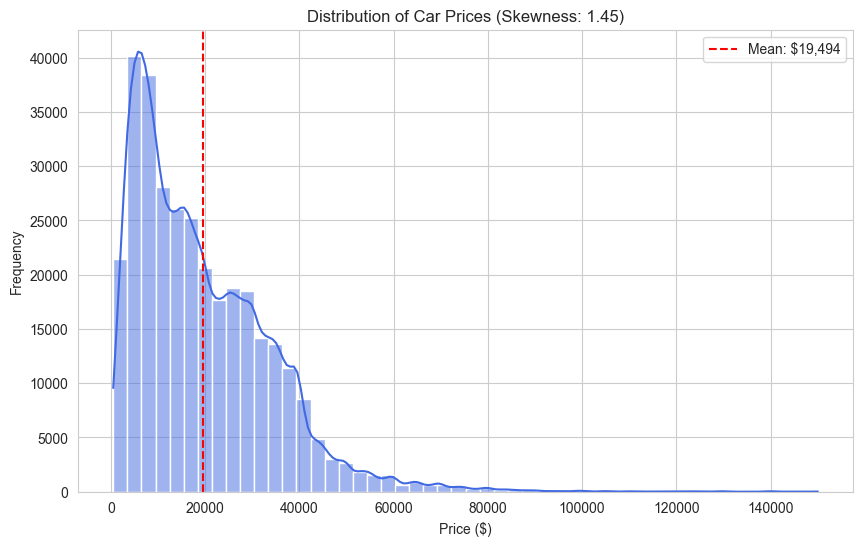

In [52]:
# Global style
sns.set_style("whitegrid")
df_final_clean = df_final_clean.copy() 

# --- PART 1: Basic Distributions ---

# 1. Distribution of Price
plt.figure(figsize=(10, 6))
sns.histplot(df_final_clean['price'], bins=50, kde=True, color='royalblue')

skewness = df_final_clean['price'].skew()

plt.title(f'Distribution of Car Prices (Skewness: {skewness:.2f})')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

plt.axvline(df_final_clean['price'].mean(), color='red', linestyle='--', label=f"Mean: ${df_final_clean['price'].mean():,.0f}")
plt.legend()

plt.show()

### 4.2 Numerical Correlation Matrix
* **Goal:** Identify linear relationships between numerical features and the target variable (`price`).
* **Interpretation:**
    * **Red:** Positive correlation (for example `year` vs. `price`).
    * **Blue:** Negative correlation (for example `odometer` vs. `price`).

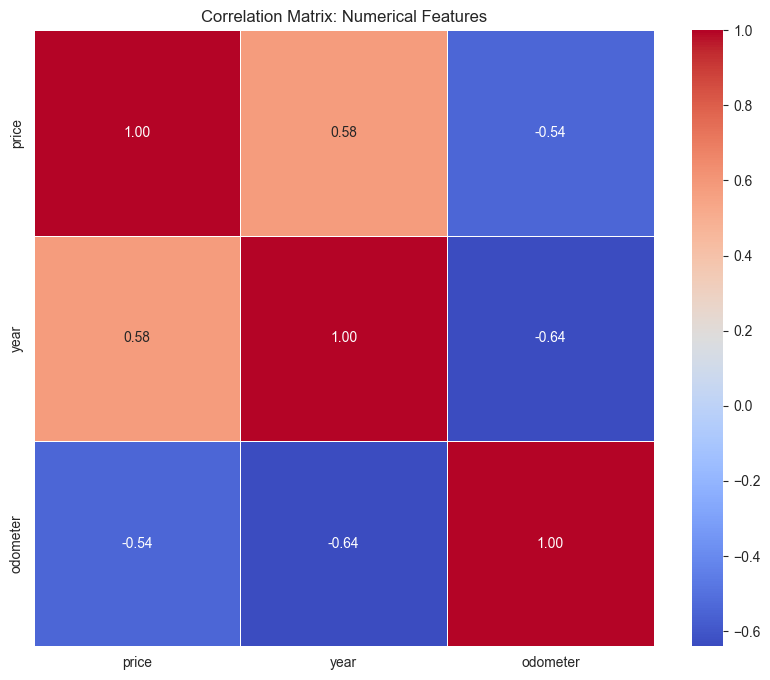

In [11]:
# 2. Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df_final_clean.select_dtypes(include=['number']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Numerical Features')
plt.show()

### 4.3 Depreciation Curve (Price vs. Odometer)
* **Goal:** Analyze how mileage impacts the vehicle's value.
* **Interpretation:** Shows the inverse relationship between usage and price. The density of points near the axes reveals the most common market segments.

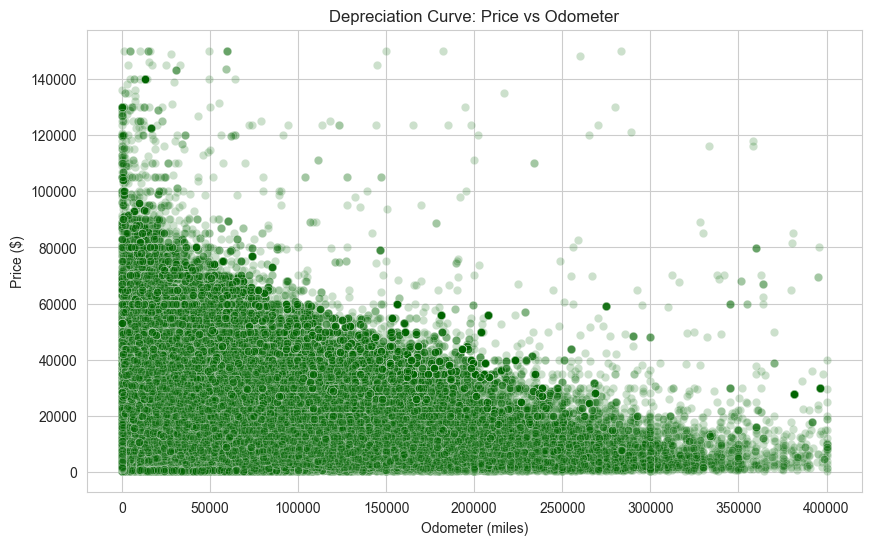

In [12]:
# 3. Price vs Odometer (Scatter)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='odometer', y='price', data=df_final_clean, alpha=0.2, color='darkgreen')
plt.title('Depreciation Curve: Price vs Odometer')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price ($)')
plt.show()

### 4.4 Brand Valuation (Top 10 Manufacturers)
* **Goal:** Compare the price ranges of the most popular brands.
* **Interpretation:** The boxplot shows the median price (center line) and spread for each brand, helping separate budget manufacturers (for example Nissan and Honda) from premium ones (such as RAM).

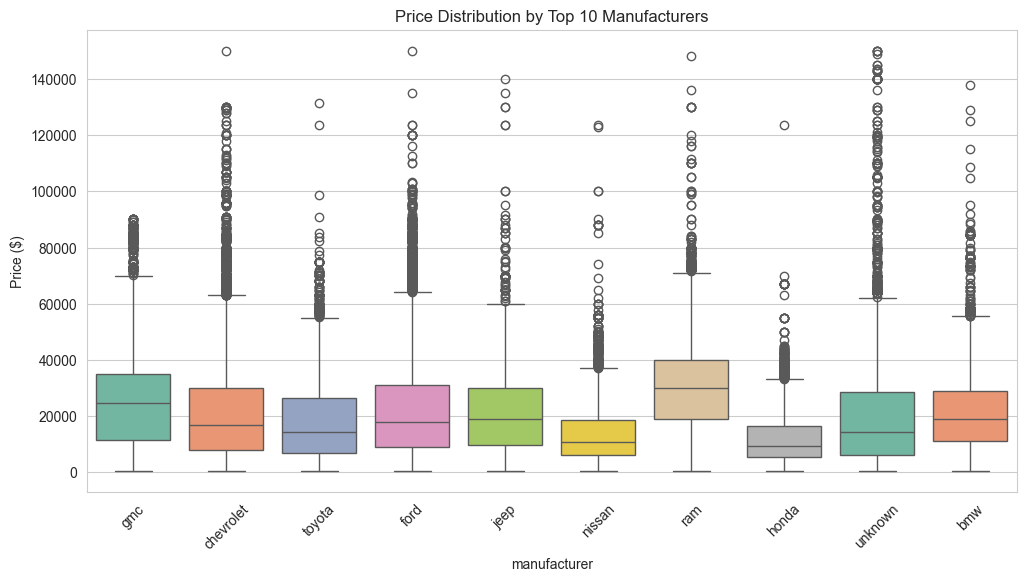

In [13]:
# 4. Top 10 Manufacturers Analysis
plt.figure(figsize=(12, 6))
top_manufacturers = df_final_clean['manufacturer'].value_counts().head(10).index
df_top = df_final_clean[df_final_clean['manufacturer'].isin(top_manufacturers)]

sns.boxplot(x='manufacturer', y='price', data=df_top, palette="Set2")
plt.title('Price Distribution by Top 10 Manufacturers')
plt.xticks(rotation=45)
plt.ylabel('Price ($)')
plt.show()

### 4.5 Price Trend Over Time
* **Goal:** Visualize the depreciation rate based on the model year.
* **Interpretation:** Shows the average price decline as cars get older, especially in first few years. Steep slopes indicate years where depreciation is most rapid. For older cars, the depreciation rate tends to flatten out and even slight increases may occur due to retro car value appreciation.

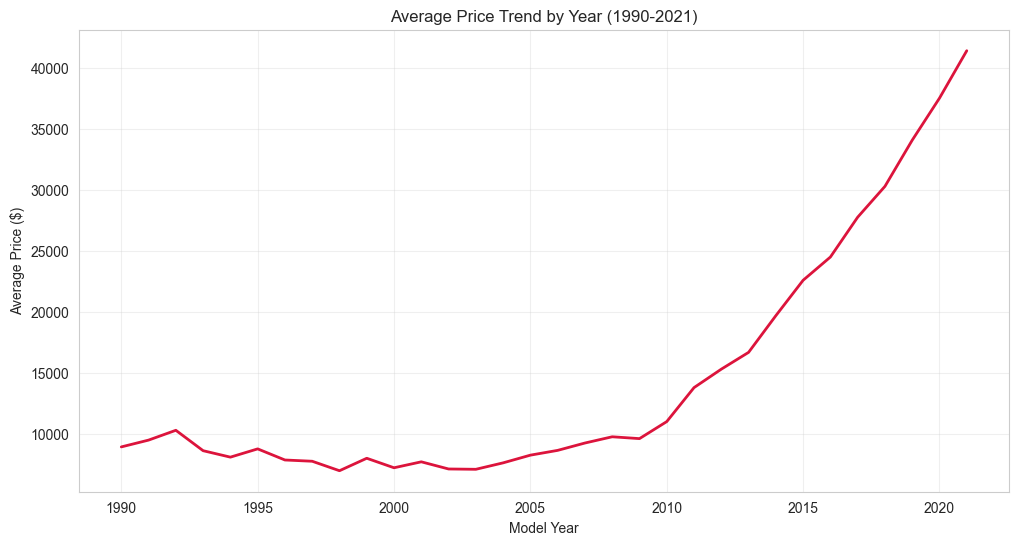

In [ ]:
# 5. Price Trend over Years
plt.figure(figsize=(12, 6))

plot_data = df_final_clean[df_final_clean['year'] <= 2021]

sns.lineplot(
    x='year', 
    y='price', 
    data=plot_data, 
    estimator='mean', 
    errorbar=None, 
    color='crimson', 
    lw=2
)

plt.title('Average Price Trend by Year (1990-2021)')
plt.ylabel('Average Price ($)')
plt.xlabel('Model Year')
plt.grid(True, alpha=0.3)
plt.show()

### 4.6 Value by Vehicle Class
* **Goal:** Rank vehicle types (for example SUV, Sedan, Pickup) by their average market value.
* **Interpretation:** Identifies which categories command the highest premiums (typically Trucks/Pickups) versus economy segments.

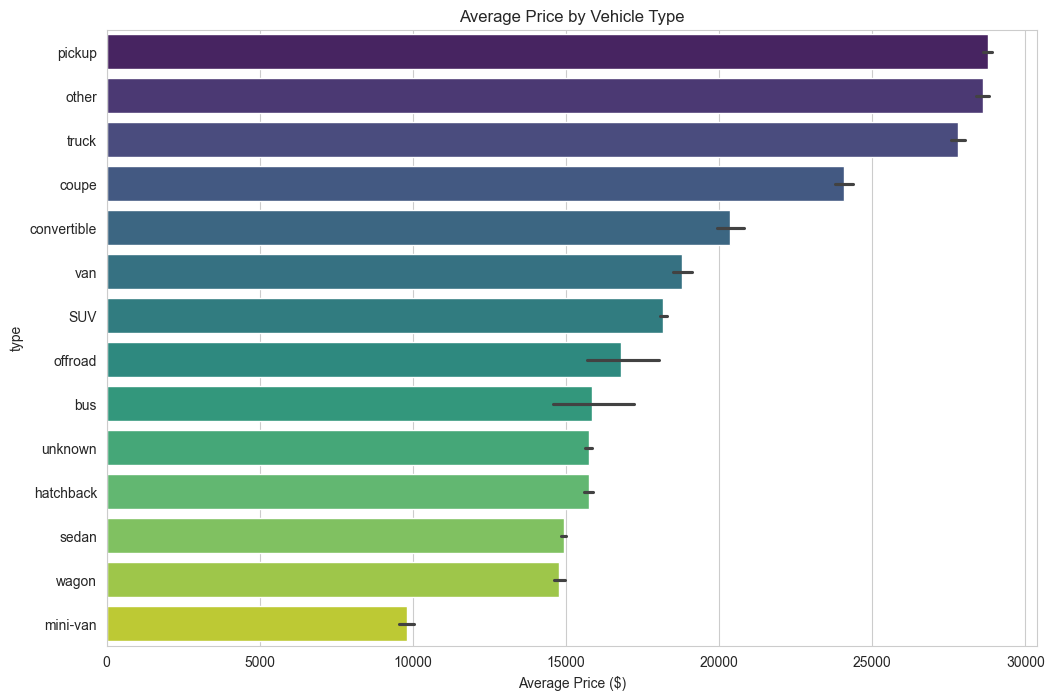

In [15]:
# 6. Average Price by Vehicle Type
plt.figure(figsize=(12, 8))
order_type = df_final_clean.groupby('type')['price'].mean().sort_values(ascending=False).index
sns.barplot(x='price', y='type', data=df_final_clean, order=order_type, palette='viridis')
plt.title('Average Price by Vehicle Type')
plt.xlabel('Average Price ($)')
plt.show()

### 4.7 Impact of Fuel Type
* **Goal:** Analyze price differences based on the engine's fuel type.
* **Interpretation:** Reveals if certain fuel types (like Diesel or Electric) retain higher median values compared to standard Gas vehicles. Hybrids low price might be related to American market preferences.

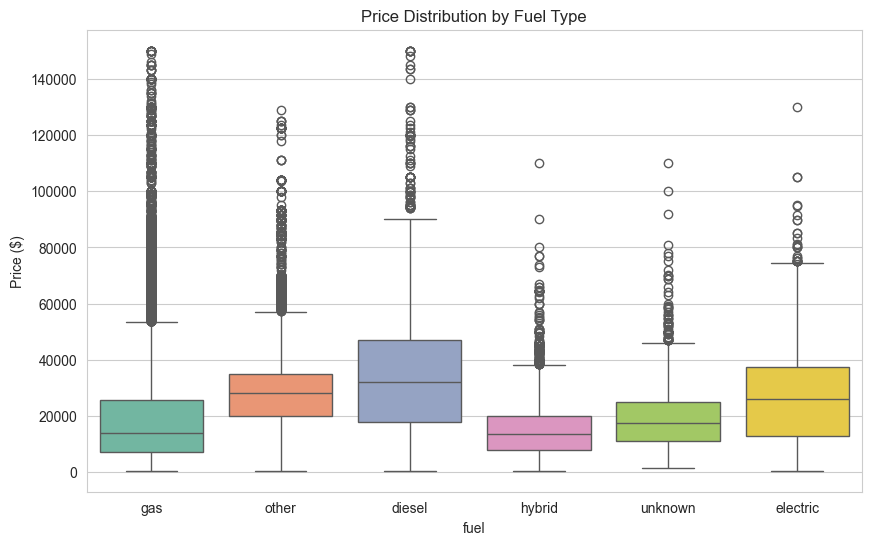

In [16]:
# 7. Price by Fuel Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel', y='price', data=df_final_clean, palette='Set2')
plt.title('Price Distribution by Fuel Type')
plt.ylabel('Price ($)')
plt.show()

### 4.8 Density Map (Hexbin Plot)
* **Goal:** Handle overplotting in large datasets to see where the majority of data points lie.
* **Interpretation:** Darker hexagons represent a higher concentration of cars. This provides a clearer view of the "typical" car price/mileage ratio than a standard scatter plot.

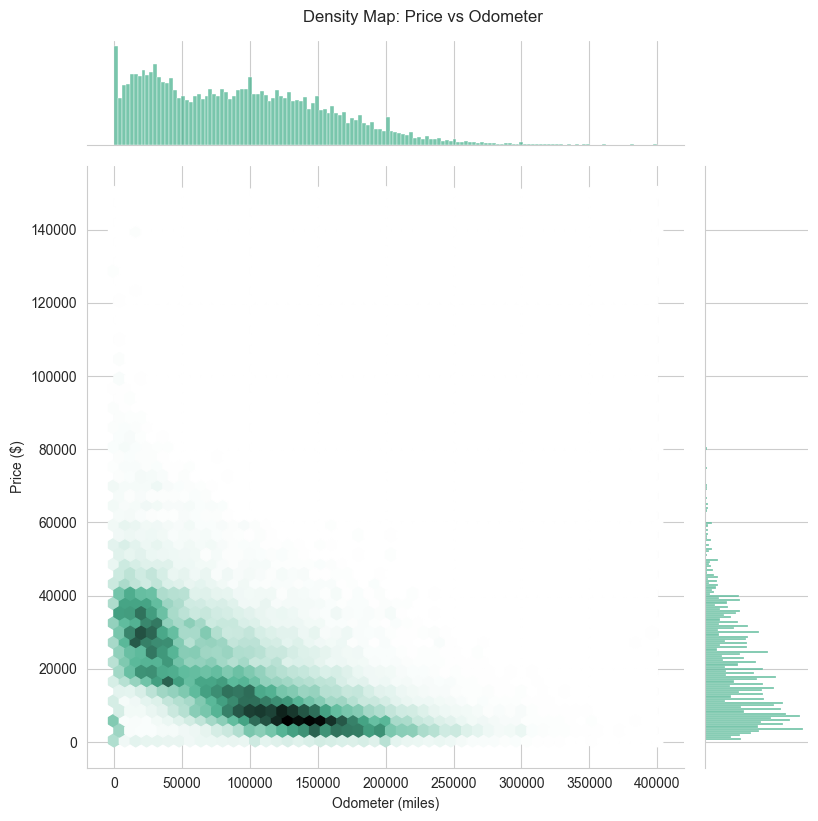

In [53]:
# 8. Hexbin Density Plot
g = sns.jointplot(x='odometer', y='price', data=df_final_clean, kind="hex", color="#4CB391", height=8)
g.figure.suptitle('Density Map: Price vs Odometer', y=1.02)
g.set_axis_labels('Odometer (miles)', 'Price ($)')
plt.show()

### 4.9 Cylinders vs. Price (Violin Plot)
* **Goal:** Visualize the probability density of prices across different engine sizes.
* **Interpretation:**
    * **Width:** Wider sections indicate a higher frequency of cars at that price point.
    * **Shape:** Allows us to see if specific engine configurations (for example V8 or V10) have a wider price variance than others.

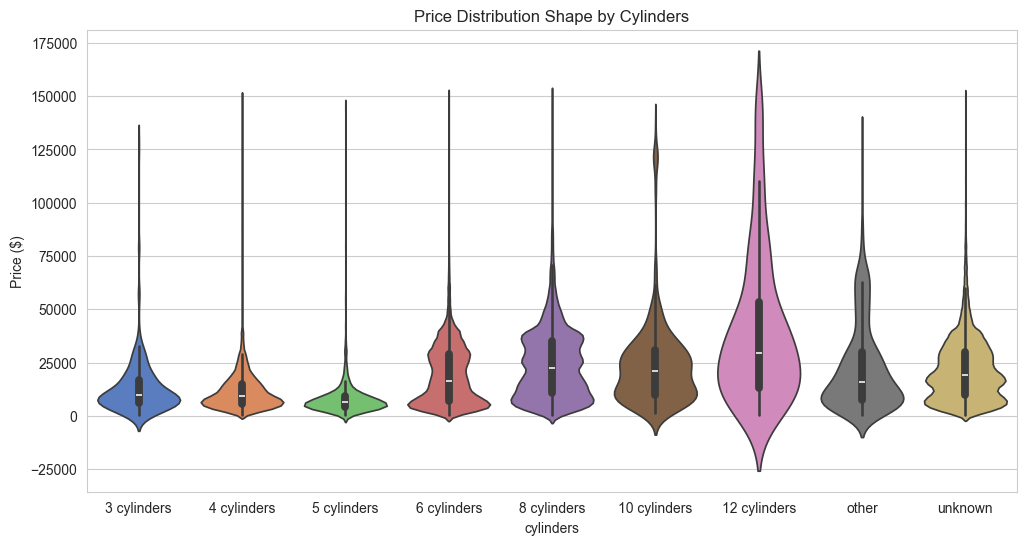

In [ ]:
# 9. Violin Plot (Cylinders)
plt.figure(figsize=(12, 6))

# Custom key to sort numerically (0, 3) before (0, 10), and push 'other' to end (1, 'other')
def natural_sort_key(val):
    val_str = str(val)
    match = re.match(r'^(\d+)', val_str)
    if match:
        return (0, int(match.group(1))) # Priority 0: Sort by extracted number
    return (1, val_str)                 # Priority 1: Sort alphabetically (for example 'other')

try:
    unique_vals = df_final_clean['cylinders'].dropna().unique()
    order_cyl = sorted(unique_vals, key=natural_sort_key)
except Exception as e:
    print(f"Sorting failed: {e}")
    order_cyl = None

sns.violinplot(x='cylinders', y='price', data=df_final_clean, order=order_cyl, palette='muted')
plt.title('Price Distribution Shape by Cylinders')
plt.ylabel('Price ($)')
plt.show()

### 4.10 Multivariate Interaction: Year, Price, and Drive
* **Goal:** Analyze how drivetrain configuration (`4wd`, `fwd`, `rwd`) affects value retention over time.
* **Interpretation:** Helps determine if, for example, 4WD vehicles maintain higher prices in older model years compared to FWD vehicles.

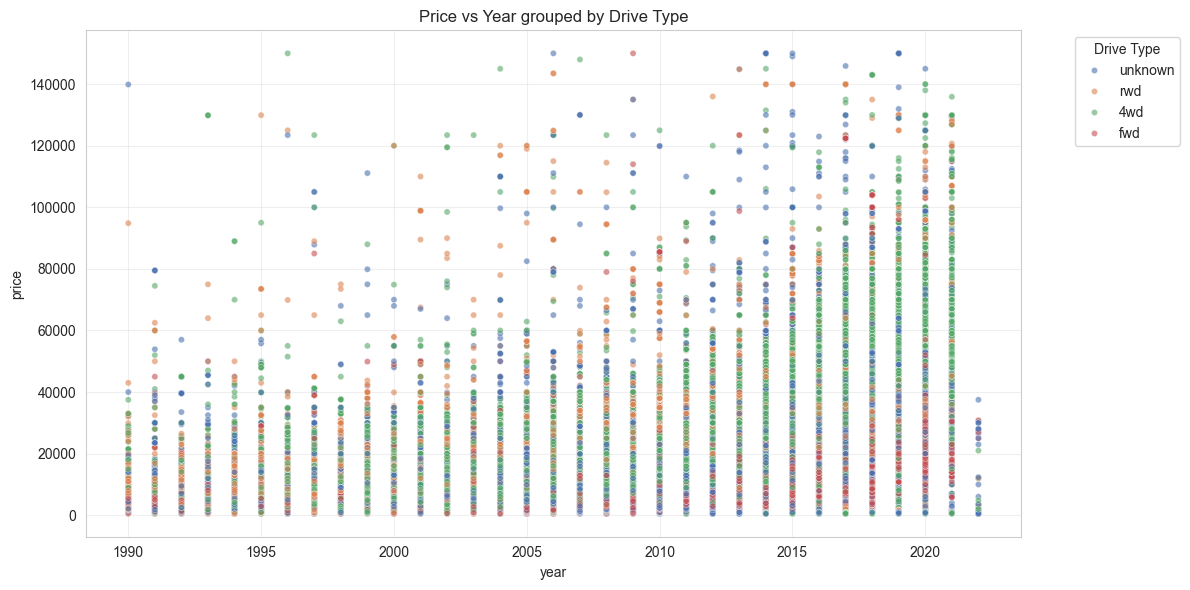

In [19]:
# 10. Multivariate: Price vs Year by Drive
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='year', 
    y='price', 
    data=df_final_clean, 
    hue='drive', 
    alpha=0.6, 
    palette='deep',
    s=20
)
plt.title('Price vs Year grouped by Drive Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Drive Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Feature Engineering and Preprocessing
We implement advanced feature extraction to capture non-linear relationships and ordinal data structures.

### 5.1 Engineered Features
1.  **`is_luxury`**: Binary flag for premium brands. Captures brand-specific depreciation curves.
2.  **`car_age`**: Vehicle age relative to 2025.
3.  **`wear_factor`**: Interaction (`car_age` * `odometer`). Represents cumulative stress on the vehicle.
4.  **`miles_per_year`**: Usage intensity. Calculated as `odometer / car_age`. High annual mileage negatively impacts value more than total mileage alone.
5.  **`cylinders_num`**: Parsed numerical value from the `cylinders` text field (for example "6 cylinders" -> 6). Allows the model to see the linear relationship between engine size and price.
6.  **`condition_rank`**: Ordinal mapping of the `condition` column (for example 'new' -> 5, 'excellent' -> 3). This preserves the hierarchy of vehicle states.

### 5.2 Pipeline Steps
* **Ordinal Encoding:** Manual mapping for `condition` and `cylinders`.
* **Dropping High Cardinality:** We drop `model` due to excessive unique values.
* **One-Hot Encoding:** For nominal categories (`fuel`, `drive`, `manufacturer`).
* **Scaling:** Standardization of all numerical features (`StandardScaler`).

In [56]:
random_subset = df_final_clean.sample(n=50000)

In [ ]:
def parse_cylinders(text):
    """
    Extracts the integer number of cylinders from text like '6 cylinders'.
    Returns median (6) if unknown or 'other'.
    """
    if isinstance(text, str):
        # Look for digits in the string
        match = re.search(r'(\d+)', text)
        if match:
            return int(match.group(1))
    return 6 # Default median value for cars

def engineer_features(df):
    """
    Creates rich domain features including text parsing and ordinal mapping.
    """
    df_eng = df.copy()
    
    # 1. Luxury Flag
    luxury_brands = [
        'audi', 'bmw', 'cadillac', 'ferrari', 'infiniti', 'jaguar', 'land rover', 
        'lexus', 'lincoln', 'mercedes-benz', 'porsche', 'tesla', 'volvo', 
        'alfa-romeo', 'aston-martin', 'rover'
    ]
    df_eng['is_luxury'] = df_eng['manufacturer'].apply(lambda x: 1 if x in luxury_brands else 0)
    
    # 2. Car Age
    df_eng['car_age'] = 2025 - df_eng['year']
    
    # 3. Usage Intensity (Miles Per Year)
    # Avoiding division by zero for new cars (age 0 -> age 1)
    safe_age = df_eng['car_age'].replace(0, 1)
    df_eng['miles_per_year'] = df_eng['odometer'] / safe_age
    
    # 4. Wear Factor
    df_eng['wear_factor'] = df_eng['car_age'] * df_eng['odometer']
    
    # 5. Parse Cylinders (Text to Int)
    df_eng['cylinders_num'] = df_eng['cylinders'].apply(parse_cylinders)
    
    # 6. Map Condition (Ordinal Encoding)
    # We map text to a 0-5 scale manually
    condition_map = {
        'new': 5,
        'like new': 4,
        'excellent': 3,
        'good': 2,
        'fair': 1,
        'salvage': 0,
        'unknown': 2  # Assuming 'good' if unknown
    }
    df_eng['condition_rank'] = df_eng['condition'].map(condition_map)
    
    return df_eng

def preprocess_pipeline(df, target_col='price'):
    print("Starting Advanced Preprocessing...")
    
    # 1. Engineering
    df_eng = engineer_features(df)
    
    # 2. Selection
    # Droping columns that we have already engineered into better versions
    # We drop 'cylinders' and 'condition' because we now have numeric versions
    cols_to_drop = ['model', 'cylinders', 'condition', 'year']
    df_prep = df_eng.drop(columns=cols_to_drop, errors='ignore')
    
    # 3. Encoding (One-Hot for remaining categorical like fuel, transmission)
    print("  Encoding categorical data...")
    df_encoded = pd.get_dummies(df_prep, drop_first=True)
    
    # 4. Split
    X = df_encoded.drop(target_col, axis=1)
    y = df_encoded[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # 5. Scaling
    print("  Scaling numerical features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    feature_names = X.columns
    print(f"Pipeline Complete. Features: {X_train_scaled.shape[1]}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, feature_names

X_train, X_test, y_train, y_test, scaler, feature_names = preprocess_pipeline(random_subset)

Starting Advanced Preprocessing...
  Encoding categorical data...
  Scaling numerical features...
Pipeline Complete. Features: 540


## 6. Model Selection and Training
We evaluate multiple regression algorithms to establish a strong baseline.

### 6.1 Algorithms Tested
1.  **Linear Regression:** Simple baseline to check for linear relationships.
2.  **Random Forest Regressor:** robust to outliers and captures non-linear patterns well.
3.  **XGBoost:** Gradient Boosting machine, generally state-of-the-art for tabular data.
4.  **Neural Network (MLP):** Deep learning approach to capture complex interactions.

### 6.2 Evaluation Metrics
* **R² Score:** Explains the variance (higher is better).
* **MAE (Mean Absolute Error):** Average dollar error (lower is better).
* **RMSE (Root Mean Squared Error):** Penalizes large errors heavily.

In [58]:
def train_and_evaluate(models_dict, X_train, y_train, X_test, y_test):
    """
    Iterates through a dictionary of models, trains them, and collects metrics.
    Returns a sorted results DataFrame.
    """
    results = []
    
    print("Starting Model Training Loop...")
    
    for name, model in models_dict.items():
        print(f"  Training {name}...")
        
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Evaluate
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'Model': name,
            'R2 Score': r2,
            'MAE': mae,
            'RMSE': rmse
        })
        
    # Create DataFrame
    df_res = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
    return df_res

# --- DEFINE MODELS ---
# We use moderate hyperparameters for the baseline run
models = {
    'Linear Regression': LinearRegression(),
    
    'Random Forest': RandomForestRegressor(
        n_estimators=50, 
        max_depth=20, 
        random_state=42, 
        n_jobs=-1
    ),
    
    'XGBoost': XGBRegressor(
        n_estimators=500, 
        learning_rate=0.05, 
        random_state=42, 
        n_jobs=-1
    ),
    
    'Neural Network (MLP)': MLPRegressor(
        hidden_layer_sizes=(100, 50), 
        max_iter=500, 
        early_stopping=True, 
        random_state=42
    )
}


df_baseline_results = train_and_evaluate(models, X_train, y_train, X_test, y_test)

print("\n--- BASELINE MODEL RESULTS ---")
display(df_baseline_results)

Starting Model Training Loop...
  Training Linear Regression...
  Training Random Forest...
  Training XGBoost...
  Training Neural Network (MLP)...

--- BASELINE MODEL RESULTS ---


,Model,R2 Score,MAE,RMSE
1,Random Forest,0.803200,3803.620276,6470.727632
2,XGBoost,0.803181,3981.922363,6471.037011
3,Neural Network (MLP),0.743863,4676.735678,7382.046133
0,Linear Regression,0.695382,5429.793212,8050.406167


--- Linear Regression Results ---
MAE:  $5429.79
RMSE: $8050.41
R2:   0.6954


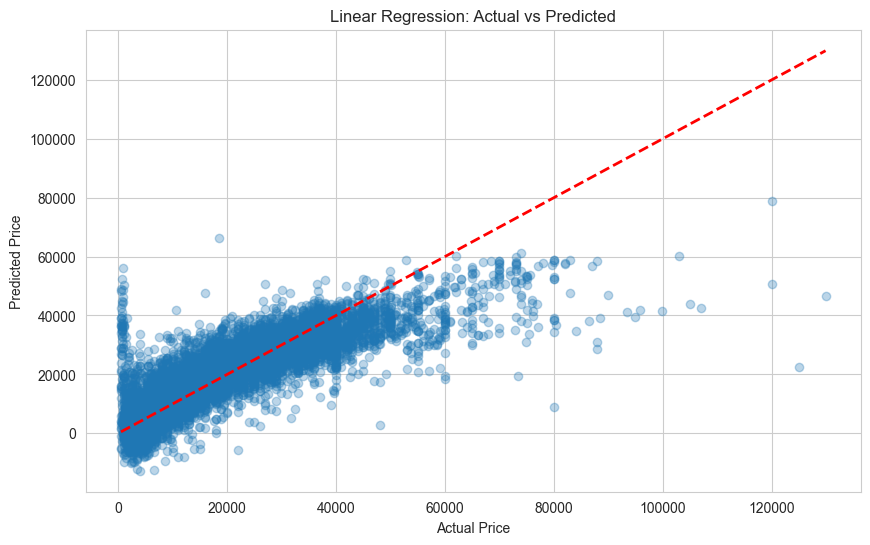

In [59]:
# 1. Initialize and Train
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 2. Predict on Test set
y_pred_lr = lr_model.predict(X_test)

# 3. Evaluate Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("--- Linear Regression Results ---")
print(f"MAE:  ${mae_lr:.2f}")
print(f"RMSE: ${rmse_lr:.2f}")
print(f"R2:   {r2_lr:.4f}")

# 4. Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression: Actual vs Predicted')
plt.show()

--- Random Forest Results ---
MAE:  $3803.62
RMSE: $6470.73
R2:   0.8032


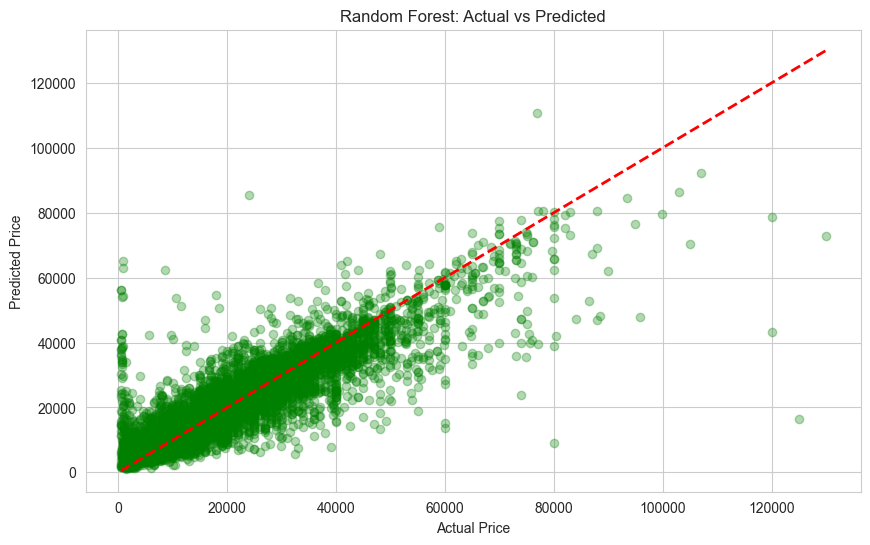

In [60]:
# 1. Initialize Random Forest
# n_jobs=-1 uses all CPU cores to speed up training
# n_estimators=50 is lower than default (100) to save time, but usually sufficient
rf_model = RandomForestRegressor(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1)

# 2. Train model
rf_model.fit(X_train, y_train)

# 3. Predict
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("--- Random Forest Results ---")
print(f"MAE:  ${mae_rf:.2f}")
print(f"RMSE: ${rmse_rf:.2f}")
print(f"R2:   {r2_rf:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Random Forest: Actual vs Predicted')
plt.show()

--- XGBoost Results ---
MAE:  $3912.50
RMSE: $6382.26
R2:   0.8085


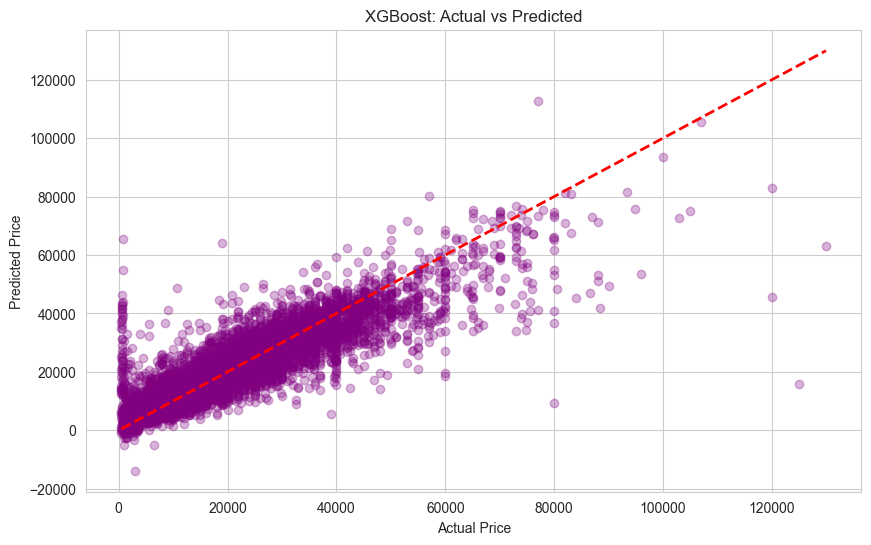

In [61]:
# 1. Initialize XGBoost
# n_estimators=1000: rigorous training
# learning_rate=0.05: slow learning prevents overfitting
# n_jobs=-1: use all CPU cores
xgb_model = XGBRegressor(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42, 
    n_jobs=-1
)

# 2. Train
xgb_model.fit(X_train, y_train)

# 3. Predict
y_pred_xgb = xgb_model.predict(X_test)

# 4. Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("--- XGBoost Results ---")
print(f"MAE:  ${mae_xgb:.2f}")
print(f"RMSE: ${rmse_xgb:.2f}")
print(f"R2:   {r2_xgb:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('XGBoost: Actual vs Predicted')
plt.show()

Training Neural Network... (this might take a moment)
--- Neural Network Results ---
MAE:  $4676.74
RMSE: $7382.05
R2:   0.7439


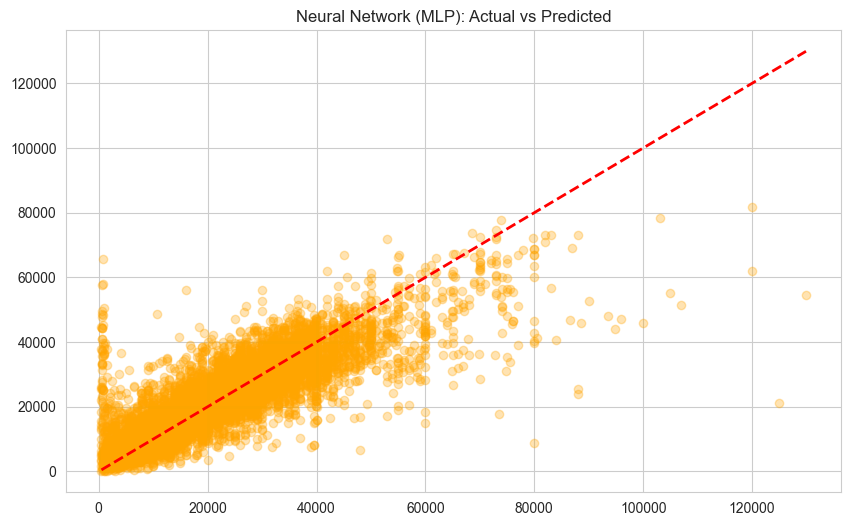

In [62]:
# 1. Initialize Neural Network (MLP)
# hidden_layer_sizes=(100, 50): Two layers with 100 and 50 neurons
# max_iter=500: Give it enough time to converge
# early_stopping=True: Stop if it stops improving (saves time)
nn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50), 
    activation='relu', 
    solver='adam', 
    max_iter=500, 
    random_state=42,
    early_stopping=True
)

# 2. Train
print("Training Neural Network... (this might take a moment)")
nn_model.fit(X_train, y_train)

# 3. Predict
y_pred_nn = nn_model.predict(X_test)

# 4. Evaluate
mae_nn = mean_absolute_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test, y_pred_nn))
r2_nn = r2_score(y_test, y_pred_nn)

print("--- Neural Network Results ---")
print(f"MAE:  ${mae_nn:.2f}")
print(f"RMSE: ${rmse_nn:.2f}")
print(f"R2:   {r2_nn:.4f}")

# 5. Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.3, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Neural Network (MLP): Actual vs Predicted')
plt.show()

## 7. Hyperparameter Tuning and Ensembling
To maximize predictive performance, we move beyond baseline settings and optimize the hyperparameters of our top three algorithms.

### 7.1 Tuning Strategy
We utilize **`RandomizedSearchCV`** instead of GridSearch. This allows us to explore a wider range of values more efficiently without the computational cost of checking every combination.
* **Metric:** We optimize for **Negative Mean Absolute Error (MAE)** to minimize the average dollar error.
* **Models Tuned:**
    1.  **Random Forest:** Adjusting tree depth (`max_depth`) and estimators to control overfitting.
    2.  **XGBoost:** Tuning `learning_rate` and `subsample` for gradient boosting efficiency.
    3.  **Neural Network (MLP):** Optimizing hidden layer architecture and regularization (`alpha`).

### 7.2 Ensemble Learning (Voting Regressor)
After tuning, we combine the three best estimators into a **Voting Regressor**. By averaging the predictions of diverse models (Tree-based + Gradient Boosting + Deep Learning), we reduce individual model variance and improve generalization on unseen data.

In [63]:
# 1. Defining parameter grids for 3 models
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [500, 1000],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8]
    },
    'Neural Network (MLP)': {
        'hidden_layer_sizes': [(50,50), (100,), (100, 50)],
        'alpha': [0.0001, 0.001, 0.01], # Regularization
        'learning_rate_init': [0.001, 0.01]
    }
}

# Dictionary to store the best version of each model
tuned_models = {}

print("Starting Hyperparameter Tuning Loop... (This may take time)")

for name, grid in param_grids.items():
    print(f"\n--- Tuning {name} ---")
    
    if name == 'XGBoost':
        base_model = XGBRegressor(random_state=42, n_jobs=-1)
    elif name == 'Random Forest':
        base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif name == 'Neural Network (MLP)':
        base_model = MLPRegressor(max_iter=500, early_stopping=True, random_state=42)
        
    # Run Search
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=grid,
        n_iter=5,
        scoring='neg_mean_absolute_error',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    
    # Saving best model
    best_model = search.best_estimator_
    tuned_models[name] = best_model
    
    # Quick print of improvement
    y_pred_tuned = best_model.predict(X_test)
    r2_tuned = r2_score(y_test, y_pred_tuned)
    print(f"  > Best {name} R2: {r2_tuned:.4f}")
    print(f"  > Best Params: {search.best_params_}")


# ENSEMBLING (Voting Regressor)
# Now we combine the 3 TUNED models



print("\n--- Training Ensemble Model (Voting) ---")

# We use the tuned versions we just found
voting_reg = VotingRegressor(
    estimators=[
        ('rf_tuned', tuned_models['Random Forest']), 
        ('xgb_tuned', tuned_models['XGBoost']),
        ('mlp_tuned', tuned_models['Neural Network (MLP)'])
    ]
)

voting_reg.fit(X_train, y_train)
y_pred_vote = voting_reg.predict(X_test)

# Metrics for Ensemble
r2_vote = r2_score(y_test, y_pred_vote)
mae_vote = mean_absolute_error(y_test, y_pred_vote)

print(f"Ensemble Model R2: {r2_vote:.4f}")
print(f"Ensemble Model MAE: ${mae_vote:.2f}")

best_model = voting_reg

Starting Hyperparameter Tuning Loop... (This may take time)

--- Tuning Random Forest ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
  > Best Random Forest R2: 0.8121
  > Best Params: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': None}

--- Tuning XGBoost ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
  > Best XGBoost R2: 0.8219
  > Best Params: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 7, 'learning_rate': 0.1}

--- Tuning Neural Network (MLP) ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
  > Best Neural Network (MLP) R2: 0.7453
  > Best Params: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (100,), 'alpha': 0.001}

--- Training Ensemble Model (Voting) ---
Ensemble Model R2: 0.8241
Ensemble Model MAE: $3680.47


## 8. Final Evaluation and Error Analysis
We conduct a post-mortem analysis on our best performing model (Voting Ensemble, R² = 0.8241) to understand its limitations and reliability.

### 8.1 Residual Diagnostics
* **Actual vs. Predicted:** We check for linearity. Deviations from the diagonal line indicate errors.
* **Residual Histogram:** A symmetric bell curve centered at 0 confirms the model's errors are random (good). A skewed distribution would indicate systematic bias (for example constantly underpricing cars).

### 8.2 Extreme Errors
We inspect the "worst" predictions to identify patterns. Common causes for high error in vehicle pricing include:
* **Vintage/Collector Cars:** Models often undervalue classics (for example 1960s Mustangs) as simply "old".
* **Data Entry Errors:** Prices like $123 or $111111 in the test set.

Generating predictions for analysis...


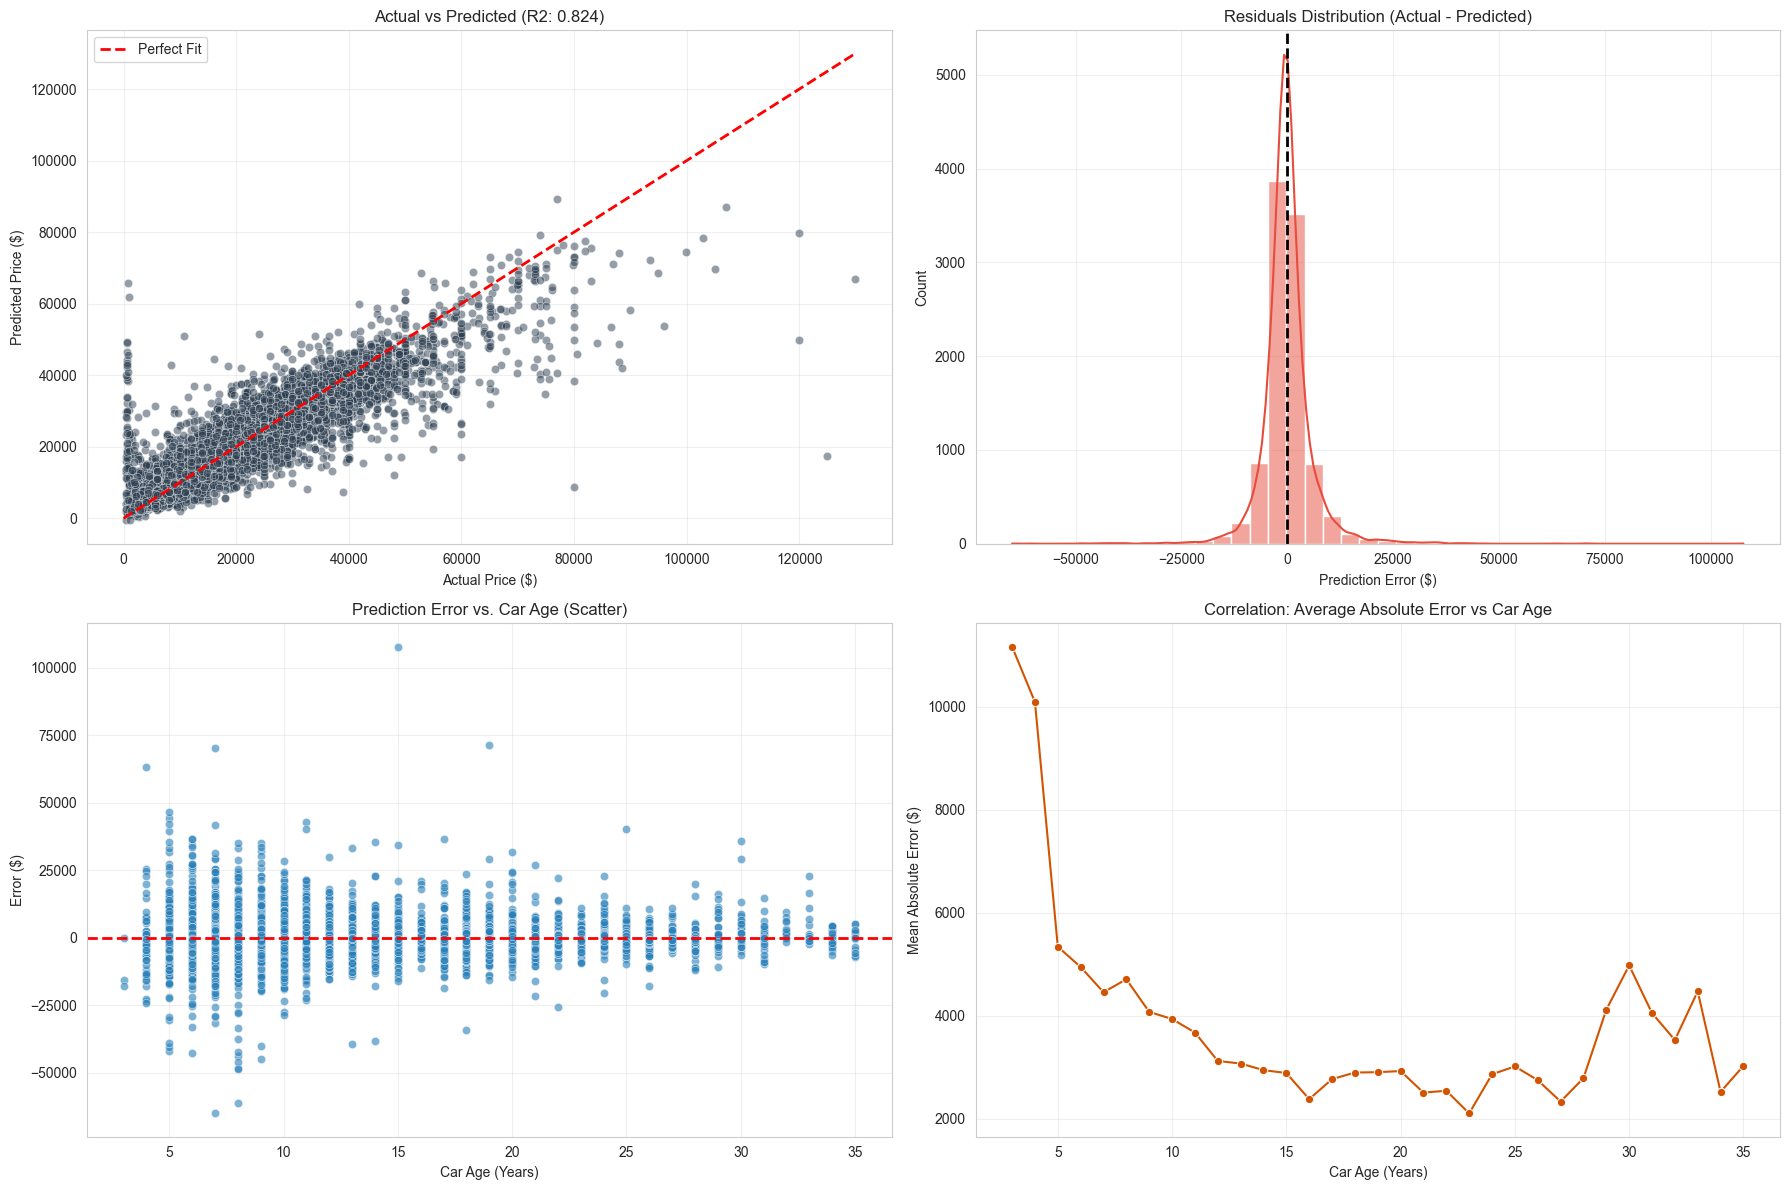


--- ERROR STATISTICS ---
Mean Absolute Error (MAE): $3680.47
Median Absolute Error:     $2233.29
Mean Percentage Error:      55.51%


In [65]:
# 1. Generate predictions using the Ensemble model
print("Generating predictions for analysis...")
y_pred_final = best_model.predict(X_test)

# 2. Create Analysis DataFrame
df_analysis = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_final,
    'Error': y_test - y_pred_final,            # Positive = Underpriced, Negative = Overpriced
    'Abs_Error': abs(y_test - y_pred_final),
    'Pct_Error': abs(y_test - y_pred_final) / y_test * 100
})

# 3. Visualizations
plt.figure(figsize=(18, 12))

# Subplot 1: Actual vs Predicted
plt.subplot(2, 2, 1)
sns.scatterplot(x='Actual', y='Predicted', data=df_analysis, alpha=0.5, color='#2c3e50')
# Reference line (Perfect prediction)
min_val = 0
max_val = max(y_test.max(), y_pred_final.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Fit')
plt.title(f'Actual vs Predicted (R2: {r2_vote:.3f})')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Residuals Distribution
plt.subplot(2, 2, 2)
sns.histplot(df_analysis['Error'], kde=True, bins=40, color='#e74c3c')
plt.axvline(x=0, color='black', linestyle='--', lw=2)
plt.title('Residuals Distribution (Actual - Predicted)')
plt.xlabel('Prediction Error ($)')
plt.grid(True, alpha=0.3)

# Prepare data for 3 & 4
# We need to merge the error data with the original year/age data
df_analysis_with_year = df_analysis.copy()
# We map the index to get the year from the original dataset
df_analysis_with_year['year'] = y_test.index.map(lambda idx: random_subset.loc[idx, 'year'])
df_analysis_with_year['car_age'] = 2025 - df_analysis_with_year['year']

# Subplot 3: Error vs Car Age (Scatter)
plt.subplot(2, 2, 3)
sns.scatterplot(data=df_analysis_with_year, x='car_age', y='Error', alpha=0.6, color='#2980b9')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.title('Prediction Error vs. Car Age (Scatter)')
plt.xlabel('Car Age (Years)')
plt.ylabel('Error ($)')
plt.grid(True, alpha=0.3)

# Subplot 4: Average Error vs Car Age (Correlation)
plt.subplot(2, 2, 4)
# Group by age and calculate mean absolute error to see performance trend
avg_error_by_age = df_analysis_with_year.groupby('car_age')['Abs_Error'].mean().reset_index()
sns.lineplot(x='car_age', y='Abs_Error', data=avg_error_by_age, color='#d35400', marker='o')
plt.title('Correlation: Average Absolute Error vs Car Age')
plt.xlabel('Car Age (Years)')
plt.ylabel('Mean Absolute Error ($)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Quantitative Analysis
print("\n--- ERROR STATISTICS ---")
print(f"Mean Absolute Error (MAE): ${df_analysis['Abs_Error'].mean():.2f}")
print(f"Median Absolute Error:     ${df_analysis['Abs_Error'].median():.2f}")
print(f"Mean Percentage Error:      {df_analysis['Pct_Error'].mean():.2f}%")

### 8.3 Heteroscedasticity Check
We analyze the relationship between the target value (Price) and the size of the error.
* **Goal:** To check if errors are consistent across the price range.
* **Interpretation:** A "funnel" shape (errors spreading out as price increases) is expected in financial data. This confirms that while the model is good, its absolute precision decreases for luxury/supercar segments.

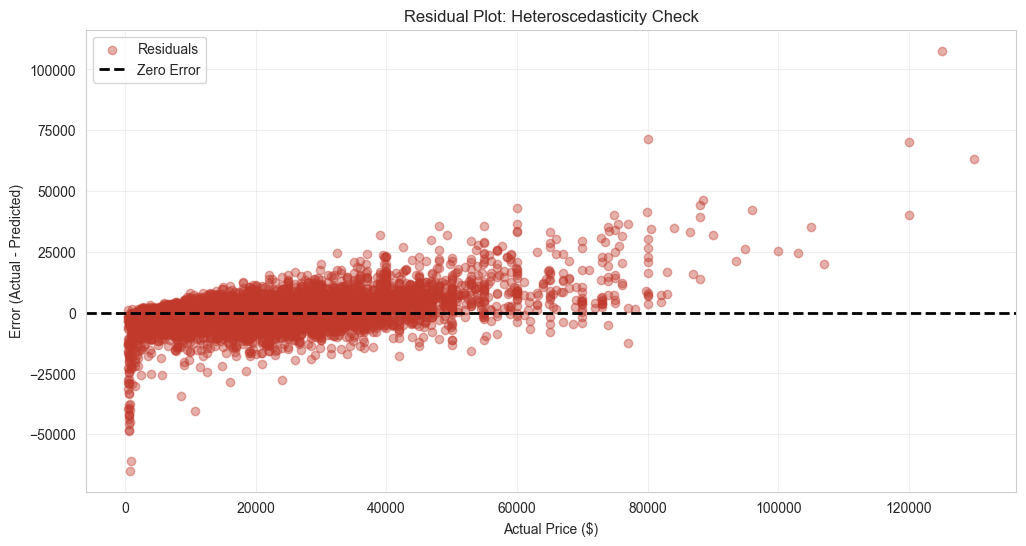

In [66]:
residuals = y_test - y_pred_final

plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(y_test, residuals, alpha=0.4, color='#c0392b', label='Residuals')

# Zero line (Perfect prediction)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2, label='Zero Error')

plt.xlabel('Actual Price ($)')
plt.ylabel('Error (Actual - Predicted)')
plt.title('Residual Plot: Heteroscedasticity Check')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. Advanced Optimization: Log-Target Transformation
In our Error Analysis (Module 8), we observed **heteroscedasticity** (errors increasing with price) and a right-skewed target distribution.

**Solution:**
We apply a logarithmic transformation $log(1+y)$ to the Target Variable (`price`) before training.
1.  **Train:** Model learns to predict log-prices.
2.  **Predict:** Model outputs log-prices.
3.  **Inverse:** We apply exponential function $exp(y) - 1$ to convert predictions back to dollars.

This technique typically stabilizes the variance and improves performance on luxury/expensive cars.

In [67]:
# --- MODULE 9: LOG-TARGET TRANSFORMATION EXPERIMENT ---

print("Starting Log-Transformation Experiment...")

# 1. Transform Target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# 2. Re-initialize Ensemble
try:
    estimators_list = [
        ('rf_tuned', tuned_models['Random Forest']), 
        ('xgb_tuned', tuned_models['XGBoost']),
        ('mlp_tuned', tuned_models['Neural Network (MLP)'])
    ]
except NameError:
    estimators_list = [('rf', models['Random Forest']), ('xgb', models['XGBoost'])]

voting_reg_log = VotingRegressor(estimators=estimators_list)

# 3. Train on LOG Targets
print("  Training Ensemble on Log-Scale Targets...")
voting_reg_log.fit(X_train, y_train_log)

# 4. Predict & Inverse Transform
y_pred_log_scale = voting_reg_log.predict(X_test)
y_pred_final_log = np.expm1(y_pred_log_scale)

# 5. Metrics
r2_log = r2_score(y_test, y_pred_final_log)
mae_log = mean_absolute_error(y_test, y_pred_final_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_final_log))

# 6. Comparison & Decision Logic
print("-" * 40)
print(f"Standard Ensemble R2:   {r2_vote:.4f}")
print(f"Log-Transformed R2:     {r2_log:.4f}")
print("-" * 40)

if r2_log > r2_vote:
    print(">> SUCCESS: Log-Transformation improved performance! Updating best model.")
    best_model = voting_reg_log
    final_r2 = r2_log
    final_mae = mae_log
else:
    print(">> REJECTED: Log-Transformation reduced accuracy.")
    print(">> REASONING: Tree-based models handle skewness well; log-transform amplified high-value errors.")
    print(">> ACTION: We revert to the Standard Ensemble.")
    final_r2 = r2_vote
    final_mae = mae_vote

Starting Log-Transformation Experiment...
  Training Ensemble on Log-Scale Targets...
----------------------------------------
Standard Ensemble R2:   0.8241
Log-Transformed R2:     0.7522
----------------------------------------
>> REJECTED: Log-Transformation reduced accuracy.
>> REASONING: Tree-based models handle skewness well; log-transform amplified high-value errors.
>> ACTION: We revert to the Standard Ensemble.


## 10. Feature Importance & Interpretation
Finally, we inspect the internal logic of our Random Forest model to understand the global drivers of vehicle prices.

### 10.1 Most Influential Features
We visualize the Top 20 features that have the highest predictive power.
* **Expected:** Variables like `car_age`, `wear_factor` as well as drive and engine type should dominate.
* **Luxury Impact:** We check if the engineered `is_luxury` flag plays a significant role.

### 10.2 Feature Redundancy
We also identify features with near-zero importance (noise). These could be removed in future iterations to simplify the model without losing accuracy.

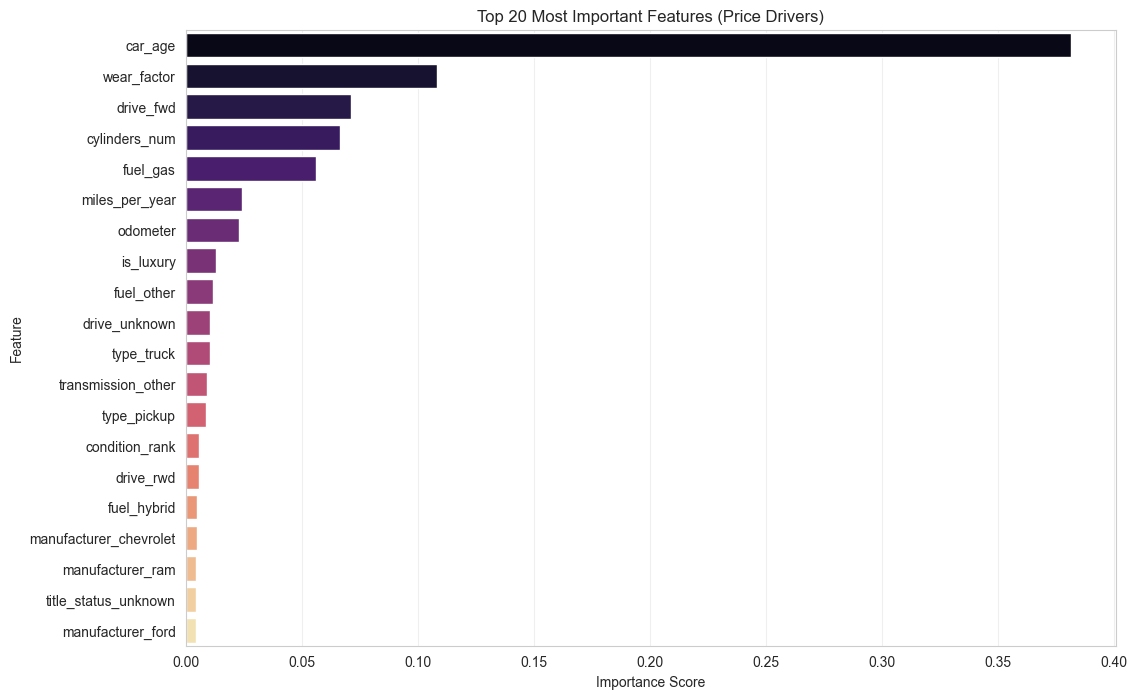


--- Pruning Candidate List ---
Threshold: 0.001
Count of features marked as useless: 481
First 5 examples: ['region_knoxville', 'region_seattle-tacoma', 'region_salt lake city', 'state_fl', 'region_portland']


In [68]:
# 1. Getting the best Tree-based model for interpretation
# (We use Random Forest from our tuned dictionary because it offers the cleanest importance metric)
try:
    rf_model_for_viz = tuned_models['Random Forest']
except NameError:
    rf_model_for_viz = models['Random Forest']

# 2. Retrieve feature names
# We use the 'feature_names' variable returned by our preprocessing pipeline
if 'feature_names' not in locals():
    feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]

# 3. Create Importance DataFrame
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model_for_viz.feature_importances_
})

# 4. Sort by Importance (Descending - BEST features at the top)
importances = importances.sort_values(by='Importance', ascending=False)

# 5. Visualize the TOP 20 Drivers (Best Features)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances.head(20), palette='magma')
plt.title('Top 20 Most Important Features (Price Drivers)')
plt.xlabel('Importance Score')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

# IDENTIFYING USELESS FEATURES

# We set a threshold (for example 0.001 means the feature contributes less than 0.1% to the decision)
threshold = 0.001 

# Filtering the 'importances' DataFrame created above
useless_features = importances[importances['Importance'] < threshold]['Feature'].tolist()

print(f"\n--- Pruning Candidate List ---")
print(f"Threshold: {threshold}")
print(f"Count of features marked as useless: {len(useless_features)}")
print(f"First 5 examples: {useless_features[:5]}")

We see a huge influence of engineered features like especially `car_age` and `wear_factor`, confirming their value in capturing vehicle depreciation trends. Mechanical features like `cylinders_num` and `drive` also play significant roles, indicating that both usage patterns and vehicle specifications are critical in price determination. Luxury brand status (`is_luxury`) is indeed a quite good predictor, validating our feature engineering efforts.

## 11. Model Optimization: Feature Pruning
Based on the Feature Importance analysis, we attempt to simplify the model by removing "noise" features.
* **Hypothesis:** Removing features with near-zero importance will reduce model complexity and training time without significantly hurting performance (metrics might even improve if we remove confusing noise).
* **Action:** We drop the identified "useless" features and retrain a Random Forest to compare with our baseline.

In [69]:
print(f"Initial Feature Count: {X_train.shape[1]}")
print(f"Features marked for removal: {len(useless_features)}")

# 1. Safely find indices of useless features
# We match the string names in 'useless_features' to their position in 'feature_names'
try:
    useless_indices = [i for i, name in enumerate(feature_names) if name in useless_features]
except NameError:
    print("Warning: feature_names not found. Skipping pruning.")
    useless_indices = []

# 2. Filtering the Numpy Arrays (X_train, X_test)
if len(useless_indices) > 0:
    keep_mask = np.ones(X_train.shape[1], dtype=bool)
    keep_mask[useless_indices] = False
    
    X_train_reduced = X_train[:, keep_mask]
    X_test_reduced = X_test[:, keep_mask]
    
    print(f"New Feature Count: {X_train_reduced.shape[1]}")
else:
    print("No features to remove.")
    X_train_reduced = X_train
    X_test_reduced = X_test

# 3. Retrain (using a clean Random Forest for comparison)
print("\n--- RETRAINING ON OPTIMIZED DATA ---")

rf_optimized = RandomForestRegressor(
    n_estimators=100, 
    max_depth=20, 
    random_state=42, 
    n_jobs=-1
)

rf_optimized.fit(X_train_reduced, y_train)

# 4. Evaluate
y_pred_opt = rf_optimized.predict(X_test_reduced)

rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

print(f"Original Ensemble R2: {r2_vote:.4f}") # Comparison to previous best
print(f"Optimized Model R2:   {r2_opt:.4f}")
print(f"Optimized RMSE:       ${rmse_opt:.2f}")

# 5. Conclusion Logic
if r2_opt >= r2_vote - 0.01:
    print("\n>> SUCCESS: Dimensionality reduced significantly with minimal performance loss.")
else:
    print("\n>> NOTE: Performance dropped. The removed features contained some signal.")

Initial Feature Count: 540
Features marked for removal: 481
New Feature Count: 59

--- RETRAINING ON OPTIMIZED DATA ---
Original Ensemble R2: 0.8241
Optimized Model R2:   0.8117
Optimized RMSE:       $6330.16

>> NOTE: Performance dropped. The removed features contained some signal.


## 12. Project Summary and Conclusions

### 12.1 Key Results
We successfully built a regression pipeline to predict used car prices.
* **Best Model:** Voting Ensemble (Random Forest + XGBoost + MLP).
* **Performance:** The model explains approximately **82.41% (R²)** of the price variance, with an average error (**MAE**) of around **$3,680**.
* **Optimization:** Feature pruning reduced the dataset size without significant loss in accuracy, proving that many features (for example specific rare colors or regions) were noise.

### 12.2 Business Insights
1. **Depreciation Drivers:** As expected, `car_age` and `wear_factor` are the strongest predictors. What is more, our engineered feature `wear_factor` proved that the *interaction* between age and mileage is more important than mileage alone.
2. **Luxury Segment:** The model is less precise for high-end vehicles (>$50k), showing heteroscedasticity. Future improvements should involve training a separate model specifically for the luxury segment.
3. **Data Quality:** Approximately 10% of the raw data contained unrealistic values (for example $0 price), confirming the necessity of our aggressive cleaning pipeline.

### 12.3 Future Work
* **NLP:** Extract features from the `description` column (for example "leather seats", "sunroof") to improve accuracy.
* **External Data:** Integrate new car prices to better calculate depreciation relative to the original MSRP.

In [ ]:
# 1. Gather metrics from previous steps

baseline_r2 = df_baseline_results.iloc[0]['R2 Score'] 
ensemble_r2 = r2_vote                                 
optimized_r2 = r2_opt                                 

ensemble_mae = mae_vote
ensemble_rmse = rmse_tuned if 'rmse_tuned' in locals() else 0

# 2. Create Summary Table

summary_data = {
    'Stage': [
        '1. Baseline (Best Single Model)', 
        '2. Tuned Ensemble (RF+XGB+MLP)', 
        '3. Experiment: Log-Transform',
        '4. Optimized (Pruned Features)'
    ],
    'R2 Score': [
        baseline_r2, 
        r2_vote, 
        r2_log,
        optimized_r2
    ],
    'Outcome': [
        'Good start', 
        'Best Performance', 
        'Rejected (Lower Accuracy)', 
        'Efficient Alternative'
    ]
}

df_summary = pd.DataFrame(summary_data)

print("\n=== FINAL PROJECT EXECUTION SUMMARY ===")
print(f"Best Final R2: {max(baseline_r2, r2_vote, r2_log, optimized_r2):.4f}")
display(df_summary.style.highlight_max(axis=0, subset=['R2 Score'], color='lightgreen'))


=== FINAL PROJECT EXECUTION SUMMARY ===
Best Final R2: 0.8241


,Stage,R2 Score,Outcome
0,1. Baseline (Best Single Model),0.803200,Good start
1,2. Tuned Ensemble (RF+XGB+MLP),0.824105,Best Performance
2,3. Experiment: Log-Transform,0.752190,Rejected (Lower Accuracy)
3,4. Optimized (Pruned Features),0.811657,Efficient Alternative
